In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from tqdm import tqdm
from transformers import BertTokenizer
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import thulac

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from wordcloud import WordCloud

from sentiment import _preprocess
from sentiment import _dataLoader 
from sentiment._model import *
from sentiment._pipeline import *

RANDOM_SEED = 2020 # random seed from sample code

device = "cuda:0"

C:\Users\admin\anaconda3\envs\cuda12\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Read Data

In [94]:
# read in and clean up raw data 
orig_data = "./data/nCov_100k/nCoV_100k_train.labled.csv"
data_path = "./data/nCov_100k/all_data.csv"

In [95]:
_preprocess.convert_to_csv(orig_data, data_path)
_preprocess.data_cleanup(data_path)

In [96]:
# display some of the data
full_data = pd.read_csv(data_path, encoding="utf-8", engine="python")
print(len(full_data))

full_data.head(10)

91060


Unnamed: 0                                             微博中文内容  情感倾向
0           0  写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...     0
1           1    开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?    -1
2           2  邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...     1
3           3                     新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?     1
4           4  问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...     1
5           5  发高烧反反复复，眼睛都快睁不开了。今天室友带我去看，还在发烧中建议我输液，我拒绝了。给我打针...    -1
6           6                       明天考试今天发烧跨年给我跨坏了？？2兰州・兰州交通大学?    -1
7           7  #元旦快乐##枇杷手法小结#每个娃都是有故事的娃。每个大人也是有故事的大人。小枇杷有茶有手法...     0
8           8  我真的服了xkh昨天vv去和她说自己不舒服，描述了症状她说啊你这不是感冒没有发烧没事的晚上一...    -1
9           9  新年第一天，为自己鼓掌??????发烧了也要来看线下演出！因为热爱，所以才会克服困难线上演出...     1

### 1.1 Distribution of semtiment types

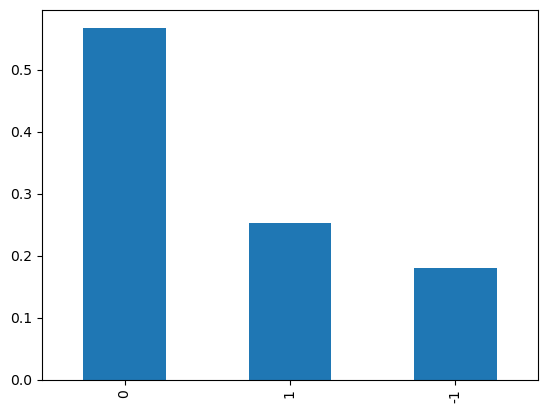

<Figure size 1000x500 with 0 Axes>

In [5]:
sample_amount = len(full_data)

(full_data["情感倾向"].value_counts()/sample_amount).plot.bar() 

fig = plt.figure(figsize = (10, 5))

In [97]:
full_data["情感倾向"].value_counts()

 0    51726
 1    22996
-1    16338
Name: 情感倾向, dtype: int64

### 1.2 Split full data into test and validation set

In [6]:
x_train, x_val, y_train, y_val = _preprocess.split_datasets(full_data, 0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((72848,), (18212,), (72848,), (18212,))

<BarContainer object of 3 artists>

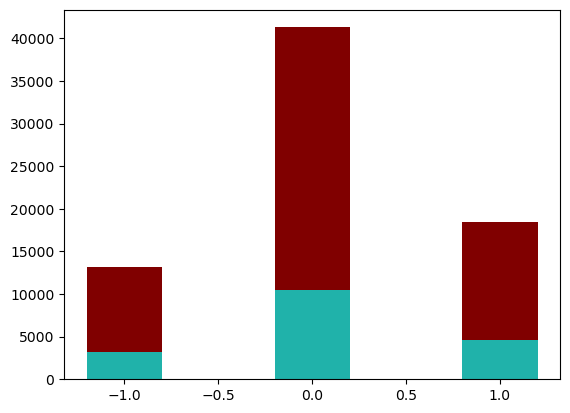

In [7]:
# we want to keep the same sentiment type distrbution in the splitted sets
val_counter = dict(Counter(y_val))
train_counter = dict(Counter(y_train))

fig = plt.figure()
plt.bar(list(train_counter.keys()), list(train_counter.values()), color ='maroon', width = 0.4)
plt.bar(list(val_counter.keys()), list(val_counter.values()), color ='lightseagreen', width = 0.4)

## 2. Data Loader

In [8]:
tokenizer_path = "hfl/chinese-roberta-wwm-ext-large"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

train_examples = _preprocess.generate_examples(x_train, y_train)
val_examples = _preprocess.generate_examples(x_val, y_val)

train_features = _preprocess.convert_examples_to_features(train_examples, tokenizer, 256)
val_features = _preprocess.convert_examples_to_features(val_examples, tokenizer, 256)

sentiment type: 1
doc tokens: ['#', '刘', '诗', '诗', '复', '工', '首', '封', '#', '刘', '诗', '诗', '欧', '米', '茄', '名', '人', '大', '使', '/', '刘', '诗', '诗', '李', '思', '雨', '/', '刘', '诗', '诗', '亲', '爱', '的', '自', '己', '/', '刘', '诗', '诗', '香', '奈', '儿', '品', '牌', '形', '象', '大', '使', '你', '眼', '中', '倒', '映', '的', '星', '河', '烂', '漫', '，', '是', '我', '不', '曾', '见', '过', '的', '世', '外', '梦', '幻', '。', '?']
sentiment type: 0
doc tokens: ['/', '/', '@', '哲', '伦', '班', '长', ':', '我', '家', '里', '人', '基', '本', '都', '戴', '上', '口', '罩', '了', '，', '我', '也', '都', '科', '普', '了', '一', '遍', '如', '视', '频', '中', '的', '口', '罩', '戴', '法', '，', '祝', '健', '康', '/', '/', '@', '韩', '松', '-', '老', '司', '机', ':', '估', '计', '大', '家', '都', '看', '看', '，', '还', '是', '转', '一', '下', '。', '1', '.', '蓝', '外', '白', '2', '.', '铝', '条', '不', '是', '捏', '的', '3', '.', '用', '过', '后', '不', '要', '触', '碰', '蓝', '色', '的', '一', '面']
sentiment type: 0
doc tokens: ['9', '0', '后', '的', '人', '如', '何', '看', '待', '2', '0', '2', '0', '年', '的', '甲', '型

  0%|                                                                              | 99/72848 [00:00<02:28, 488.44it/s]

sentiment type 1
all_doc_tokens ['[CLS]', '#', '刘', '诗', '诗', '复', '工', '首', '封', '#', '刘', '诗', '诗', '欧', '米', '茄', '名', '人', '大', '使', '/', '刘', '诗', '诗', '李', '思', '雨', '/', '刘', '诗', '诗', '亲', '爱', '的', '自', '己', '/', '刘', '诗', '诗', '香', '奈', '儿', '品', '牌', '形', '象', '大', '使', '你', '眼', '中', '倒', '映', '的', '星', '河', '烂', '漫', '，', '是', '我', '不', '曾', '见', '过', '的', '世', '外', '梦', '幻', '。', '?', '[SEP]']
doc_input_ids [101, 108, 1155, 6408, 6408, 1908, 2339, 7674, 2196, 108, 1155, 6408, 6408, 3616, 5101, 5746, 1399, 782, 1920, 886, 120, 1155, 6408, 6408, 3330, 2590, 7433, 120, 1155, 6408, 6408, 779, 4263, 4638, 5632, 2346, 120, 1155, 6408, 6408, 7676, 1937, 1036, 1501, 4277, 2501, 6496, 1920, 886, 872, 4706, 704, 948, 3216, 4638, 3215, 3777, 4162, 4035, 8024, 3221, 2769, 679, 3295, 6224, 6814, 4638, 686, 1912, 3457, 2404, 511, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  1%|▍                                                                            | 117/18212 [00:00<00:30, 590.77it/s]

sentiment type 1
all_doc_tokens ['[CLS]', '?', '?', '?', '?', '让', '我', '们', '携', '手', '行', '动', '，', '从', '自', '身', '做', '起', '?', '?', '?', '?', '?', '?', '众', '志', '成', '城', '，', '共', '克', '时', '艰', '?', '?', '?', '为', '打', '赢', '疫', '情', '防', '控', '阻', '击', '战', '贡', '献', '南', '粤', '青', '年', '学', '子', '的', '力', '量', '?', '?', '[SEP]']
doc_input_ids [101, 136, 136, 136, 136, 6375, 2769, 812, 3025, 2797, 6121, 1220, 8024, 794, 5632, 6716, 976, 6629, 136, 136, 136, 136, 136, 136, 830, 2562, 2768, 1814, 8024, 1066, 1046, 3198, 5680, 136, 136, 136, 711, 2802, 6617, 4554, 2658, 7344, 2971, 7349, 1140, 2773, 6567, 4346, 1298, 5113, 7471, 2399, 2110, 2094, 4638, 1213, 7030, 136, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|███████████████████████████████████████████████████████████████████████████| 18212/18212 [00:32<00:00, 564.43it/s]


## 3. Parameter Tuning

### 3.1 Batch Size

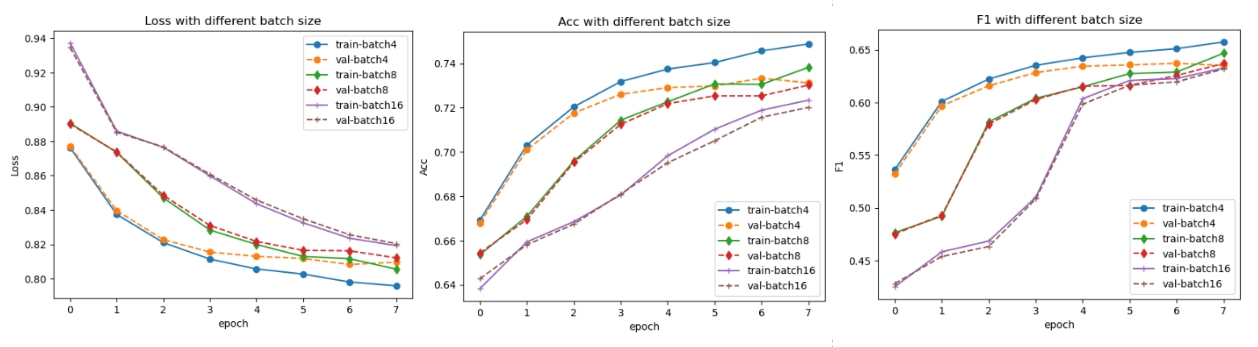  

Here we tested batch size 4, 8 16 with a LSTM with 8 layers. The learning rate is set to 1e-6. We will chosse batch size 8 and 16. Batch 4 becomes overfitting after the 6th epoch, and it's best accuracy and scores are close to batch size 8 and 16, whilst the other two are still converging and imprving.

#### 3.2 LSTM Layer Amount

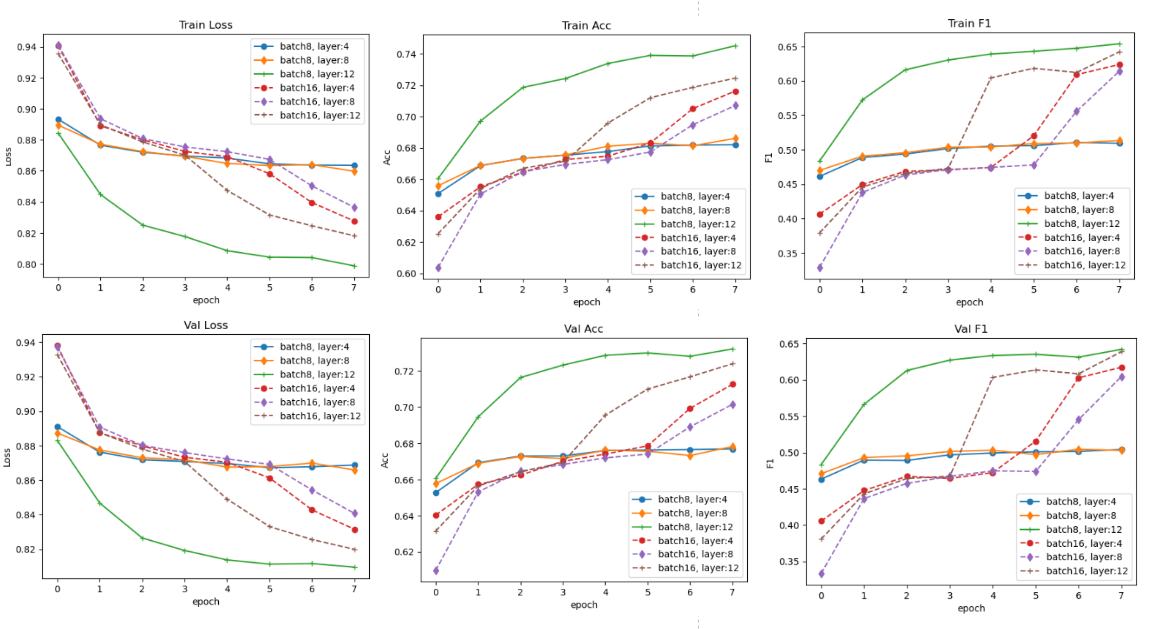  

The best accuracy and F1 scores are carried out by batch size 8 and layer amount 12. Batch size 16 with layer amount 12 also shout out a promising results. Both these two models have not finished convergence within the 8 epochs, therefore, we will run more iterations with these two hyperparameter combinations to choose our final model.  

As can observe from the above diagram, the more layers the BiLSTM has, the faster the model converges and the better the prediciton results will be. We will also try layer amount 16 in the later section for comparison.

#### 3.3 More Epochs to Pick the Final Model

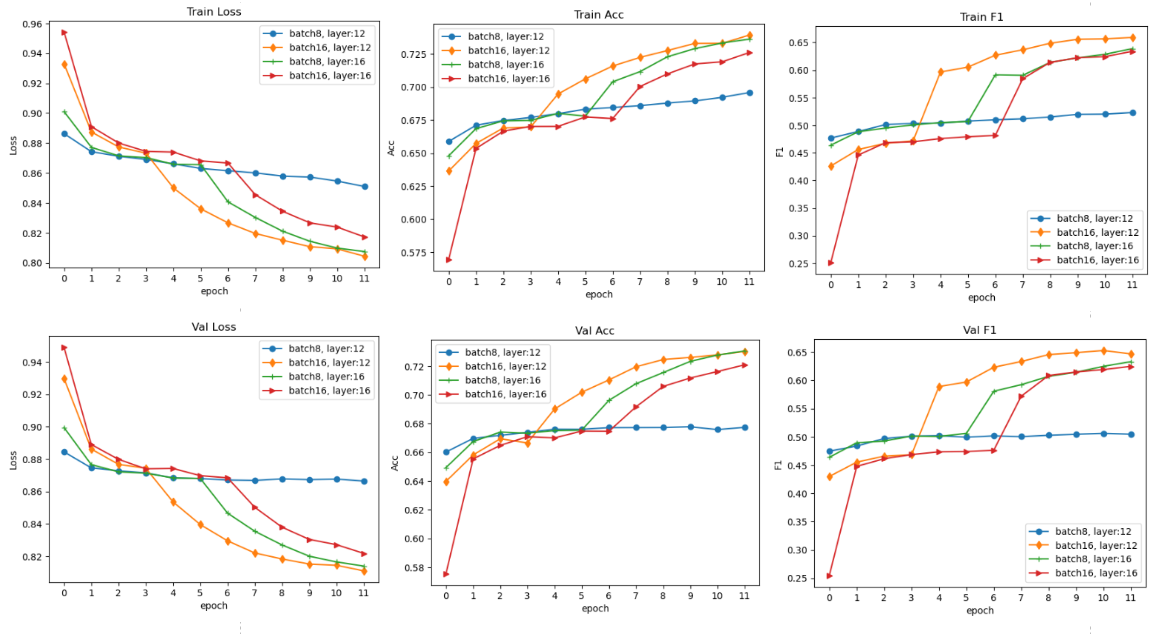  

We tested below hyperparamter combinations:  
* {'batch': 8, 'n_layer': 12}
* {'batch': 16, 'n_layer': 12}
* {'batch': 8, 'n_layer': 16}
* {'batch': 16, 'n_layer': 16}

The best model would be with batch size 16 and layer amount 16, batch size 8 and layer amount 16 has a similar result. Judging by the F1 and accuracy curves on the validation set, batch size 8 follows a trend that could exceed the performance of batch size 16. Therefore, we will choose batch size 8 for training our model. 

#### 3.4 Final Model

In [ ]:
max_epoch = 32

batch_size = 16
n_layer = 12

model_save_path = "./model_cpt/Bert_BiLSTM16_epoch"

train_loader = _dataLoader.DataIteratorPack(train_features, batch_size, device)
val_loader = _dataLoader.DataIteratorPack(val_features, batch_size, device)

# initialize model 
checkpoint = torch.load("./model_cpt/Bert_BiLSTM16_epoch7.pth")

model = SentimentClassifier("hfl/chinese-roberta-wwm-ext-large", 256, device, n_layer)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-6)
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])
criterion = criterion.to(device)

all_train_loss, all_train_acc, all_train_f1, all_val_loss, all_val_acc, all_val_f1 = [], [], [], [], [], []

prev_acc, prev_f1 = 0.735129, 0.65605
epoch_after_best_count = 0
best_epoch = 7

for epoch in range(8, max_epoch):
    print("at epoch: {}".format(epoch))
    train_loader.refresh()
    val_loader.refresh()
    val_loss, val_acc, val_f1 = train_epoch(model, train_loader, val_loader, criterion, optimizer, device)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)
    all_val_f1.append(val_f1)

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, model_save_path+str(epoch)+".pth")
    print("Current Epoch: {} -- Val Loss: {}, Val Acc:{}, Val F1:{}".format(
                epoch, val_loss, val_acc, val_f1 
            ))
    
    # early stop
    if val_f1>prev_f1 and val_acc>prev_acc:
        epoch_after_best_count = 0
        best_epoch = epoch
        prev_acc = val_acc
        prev_f1 = val_f1
        
    elif val_f1<=prev_f1 or val_acc<=prev_acc:
        epoch_after_best_count += 1
    print("Epochs after best: {}".format(epoch_after_best_count))
    if epoch_after_best_count>5:
        break
    
    

In [11]:
train_loader = _dataLoader.DataIteratorPack(train_features, 8, device)
val_loader = _dataLoader.DataIteratorPack(val_features, 1, device)

checkpoint = torch.load('./model_cpt/Bert_BiLSTM16_epoch13.pth')

model = SentimentClassifier("hfl/chinese-roberta-wwm-ext-large", 256, device, 12)
model.load_state_dict(checkpoint['state_dict'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
#optimizer.load_state_dict(checkpoint['optimizer'])

model.eval()

model.to(device)

val_epoch(model, val_loader, criterion, optimizer, device)

tensor([[ 101, 1476, 1565,  120,  120,  137, 3215, 2349, 1046,  704, 1744,  131,
         2143, 4289, 4638, 7373,  845, 1146, 2857, 4193, 5991,  510, 2109, 4324,
         8024, 2769,  812, 1355, 4385, 4263, 2110,  833, 4263,  511, 4510, 2512,
          100, 2143, 4263,  100,  712, 4028,  722,  671, 3589,  978, 3613, 3219,
         1921, 1346, 1217, 5722, 2336, 3833, 1220, 8024, 4510, 2512, 7027,  800,
         1728, 4344, 1488, 2533, 5357, 1146, 8024, 4385, 2141,  704,  800, 3221,
         3131, 1221, 3837, 3857, 4318, 4638, 4178, 2552, 2207, 1520, 1520,  511,
         1920, 2157, 4761, 6887,  800, 4385, 1767, 4500,  784,  720, 2143, 4263,
         3742, 3215,  782, 8043,  137, 3905, 4873, 4873,  137, 7350, 7027, 7824,
         6760, 1355, 2853,  122,  121,  855, 5031, 2190, 8024, 3680,  782,  123,
         2476, 4873, 8024, 1469, 4510, 2512,  100, 2143, 4263,  100,  671, 6629,
         4500, 4263, 2399, 3389, 4692, 1745, 4275,  102]], device='cuda:0')
tensor([[1., 1., 1., 1., 1., 1., 

KeyboardInterrupt: 

## 4. Quantitative Analysis  

The raw data extracted from the original json files is saved to a .csv file. We will read the data in.  

The epidemic broke out in Wuhan and the city lockdown was from January 23, 2020, and the city was closed until the end of April. The data we collected covers false rumor contents on Weibo from January 22 to March 3. The coincidence of time periods encompasses the most panicked stages of people’s emotions. In this section, we will analyze people's emotional changes during this period based on information from neural networks and machine learning.  

For better analyze, we referenced to an epidemic trimeline put up on github: https://github.com/lestweforget/COVID-19-Timeline/blob/master/%E6%97%B6%E9%97%B4%E7%BA%BFTIMELINE.md  


In [3]:
rumor_data = pd.read_csv('./data/rumor/analys_data.csv', encoding="utf-8")
full_data = pd.read_csv('./data/nCov_100k/all_data02.csv', encoding="utf-8")

### 4.1 Number of rumors on Weibo from January 22 to March 3

In [230]:
date_list = rumor_data['date'].tolist()
rumor_date_count = dict(OrderedDict(sorted(Counter(date_list).items())))

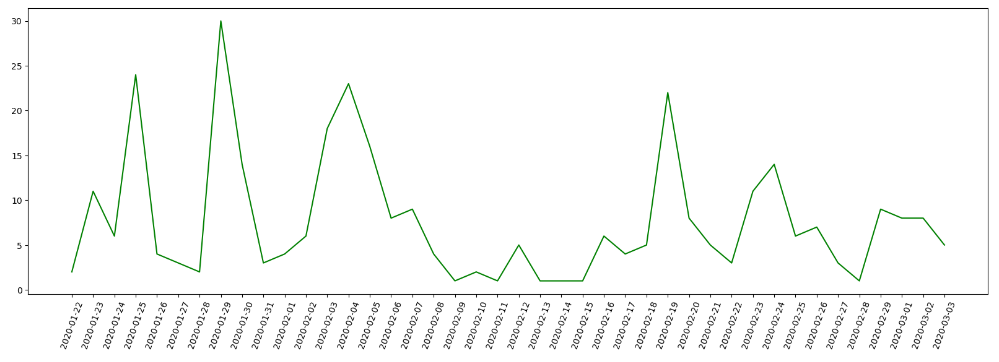

Although our rumor data is small, by combining the epidemic news timeline and the rumor quantity line chart above, we can roughly analyze the relationship between the number of rumors and events at the time.  

The number of rumors was much higher from January 22 to early February than at other subsequent times, and continued to decline in mid-February. After which the amount of rumors increased rapidly at the end of February, and entered the second peak period of rumor publishing.  

Since the Hubei Provincial Government launched the Level II public health emergency response and issued a provincial announcement on January 22, people were eager to know the truth and details of the epidemic, which led to the spread of rumors; as of January 23, the Wuhan city was officially locked down, public's anxiety, panic and other emotions have risen sharply, causing more rumors and pseudoscience to be published and spread.   

Starting from February 6, the number of rumors related to the epidemic gradually dropped to underestimation. At this time, Wuhan Leishenshan Hospital began to gradually hand over, and the work of fighting the epidemic began to advance steadily. At the same time, a large number of Weibo topic of "Pneumonia Help Super Chat" were cleared, and This resulted in a reduction in the number of rumors.  

Combined with the news event line, the time period corresponding to the second rumor peak coincides with the relaxation of control and responses on social media (such as Douban’s diary function).


### 4.2 Number of Rumors on Weibo with Different Sentiment 

In this section, we will only focus on negative/positive/neutral sentiment mining.  

By observing the missing values from the raw data, we could notice that the missing samples all have high visit times. This is probably the reason why the values are missing, since they have too negative social impact. Therefore, we will ackownledge them as pure negative sentiment for stastistic. 

With the model trained before, index 0 is negative, we will directly label them as 0 with prediction probability [1, 0, 0] in the output column appended to the dataframe later.   

We will combine the nCoV_100k data for co-analysis the connection between public's emotional tendencies and rumors. 

0 - negative, 1 - neutral, 2 - positive


In [4]:
rumor_data = rumor_data.rename(columns={'content': '微博中文内容'})  # matching the data from nCoV_100k

rumor_data['情感倾向'] = [0] * len(rumor_data)
rumor_data['logits'] = [[1, 0, 0]] * len(rumor_data)

In [5]:
y = rumor_data['情感倾向'].to_numpy()
x = rumor_data['微博中文内容'].to_numpy()

In [6]:
tokenizer_path = "hfl/chinese-roberta-wwm-ext-large"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

samples = _preprocess.generate_examples(x, y)
features = _preprocess.convert_examples_to_features(samples, tokenizer, 256)

sentiment type: 0
doc tokens: ['据', '最', '新', '研', '究', '发', '现', '，', '此', '次', '新', '型', '肺', '炎', '病', '毒', '传', '播', '途', '径', '是', '华', '南', '海', '鲜', '市', '场', '进', '口', '的', '豺', '—', '-', '一', '种', '犬', '科', '动', '物', '携', '带', '的', '病', '毒', '，', '然', '后', '传', '给', '附', '近', '的', '狗', '，', '狗', '传', '狗', '，', '狗', '传', '人', '。', '狗', '不', '生', '病', '，', '人', '生', '病', '。', '人', '生', '病', '后', '又', '传', '给', '狗', '，', '循', '环', '传', '染', '。', '据', '试', '验', '，', '带', '有', '这', '种', '病', '毒', '的', '\u2005', '狗', '周', '围', '3', '0', '米', '內', '属', '高', '风', '险', '传', '染', '区', '，', '十', '米', '之', '内', '带', '口', '罩', '没', '有', '作', '用', '。', '所', '以', '，', '人', '们', '一', '定', '要', '远', '离', '狗', '。', '养', '有', '狗', '的', '家', '庭', '要', '把', '狗', '拴', '在', '家', '中', '，', '不', '能', '逗', '狗', '了', '。', '外', '出', '时', '除', '带', '口', '罩', '外', '，', '最', '好', '还', '要', '戴', '眼', '镜', '，', '因', '为', '此', '病', '毒', '可', '通', '过', '眼', '膜', '传', '入', '人', '体', '。', '目', '前', '杀', '死', '此',

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.91it/s]

sentiment type 0
all_doc_tokens ['[CLS]', '据', '最', '新', '研', '究', '发', '现', '，', '此', '次', '新', '型', '肺', '炎', '病', '毒', '传', '播', '途', '径', '是', '华', '南', '海', '鲜', '市', '场', '进', '口', '的', '豺', '[UNK]', '-', '一', '种', '犬', '科', '动', '物', '携', '带', '的', '病', '毒', '，', '然', '后', '传', '给', '附', '近', '的', '狗', '，', '狗', '传', '狗', '，', '狗', '传', '人', '。', '狗', '不', '生', '病', '，', '人', '生', '病', '。', '人', '生', '病', '后', '又', '传', '给', '狗', '，', '循', '环', '传', '染', '。', '据', '试', '验', '，', '带', '有', '这', '种', '病', '毒', '的', '狗', '周', '围', '3', '0', '米', '內', '属', '高', '风', '险', '传', '染', '区', '，', '十', '米', '之', '内', '带', '口', '罩', '没', '有', '作', '用', '。', '所', '以', '，', '人', '们', '一', '定', '要', '远', '离', '狗', '。', '养', '有', '狗', '的', '家', '庭', '要', '把', '狗', '拴', '在', '家', '中', '，', '不', '能', '逗', '狗', '了', '。', '外', '出', '时', '除', '带', '口', '罩', '外', '，', '最', '好', '还', '要', '戴', '眼', '镜', '，', '因', '为', '此', '病', '毒', '可', '通', '过', '眼', '膜', '传', '入', '人', '体', '。', '目', '前', '杀', '死',

In [7]:
loader = _dataLoader.DataIteratorPack(features, 1, device)

# load the model for eval and predict 
checkpoint = torch.load('./model_cpt/Bert_BiLSTM16_epoch14.pth')

model = SentimentClassifier("hfl/chinese-roberta-wwm-ext-large", 256, device, 12)
model.load_state_dict(checkpoint['state_dict'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.eval()
model.to(device)

while not loader.empty():
    batch = next(iter(loader))
    batch['context_mask'] = batch['context_mask'].float().to(device)
    batch['context_idxs'] = batch['context_idxs'].to(device)

    logits = model(batch)

    
    logits = logits.detach()[0].cpu().numpy()
    pred_index = logits.argmax()

    rumor_data['logits'][batch['doc_id'][0]] = logits
    rumor_data['情感倾向'][batch['doc_id'][0]] = pred_index

C:\Users\admin\anaconda3\envs\cuda12\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
C:\Users\admin\AppData\Local\Temp\ipykernel_51152\3321212589.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rumor_data['logits'][batch['doc_id'][0]] = logits
C:\Users\admin\AppData\Local\Temp\ipykernel_51152\3321212589.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

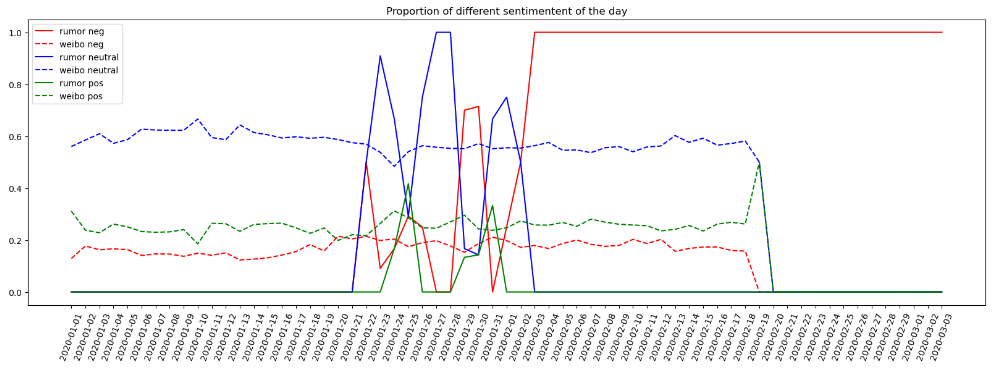  

The horizontal axis of the table is from January 1, 2020 to March 3, 2020. The data on epidemic rumors starts from January 22, and the Weibo epidemic-related information data starts from January 1 and ends on February 17. The main intersection time of the two data is from January 21 to February 17.  

The proportion of Weibo information in each emotion category to all information collected on the day has been relatively stable. Neutral emotions have always occupied the largest proportion. As the lockdown period progressed, neutral Weibo contents decreased slightly and negative comments began to increase. At the same time, by reading the data set, we can find that the proportion of positive comments increases with the in-depth research on the epidemic and the disclosure of relevant information.  

Neutral and negative emotions have always occupied the main part of rumors, and show a negative correlation with the number of positive emotion rumors. Reading the data, we can find that most of the neutral rumors belong to pseudoscience or fake social news, such as: the date to release from lockdown, etc. Rumors with positive emotions are mainly based on expectations and confidence in the country's control of the epidemic. Especially on January 29 and 30, the number of positive rumors climbed to the peak, mainly corresponding to rumor information related to Japan's evacuation of overseas Chinese. The evacuation showed the China's strength and cohesion have given the people confidence after days of control.  

After entering February, rumors about the epidemic with negative emotions surged. It can be inferred from the diagram that the vast majority of rumors at that time were basically negative emotions. Comparing the original data, it was found that the rumors with negative emotions mainly involve: 1. Uneasiness and anxiety caused by the epidemic situation and control policies; 2. Anger about the interception of relief materials by express delivery; 3. Conspiracies about the new coronavirus inhibitor remdesivir and counter-conspiracy theories; 4. Accidents caused by the indiscriminate use of alcohol for disinfection; 5. Information related to resumption of work and school. The public's uneasiness was growing day by day, and there is a stronger negative reaction to the instability and unknown of epidemic treatment, disease prevention, and life security.  

### 4.3 Spread of epidemic rumors

Based on the analysis above, we will clip the rumor data to three stages: 22 Januaray to 28 January, 29 Januaray to 2 Februray, and time afterwards.  

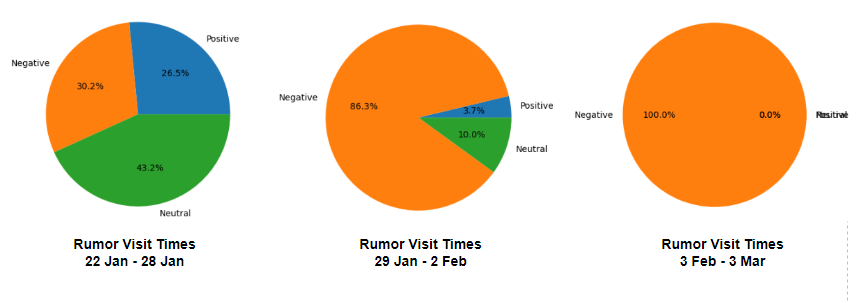  

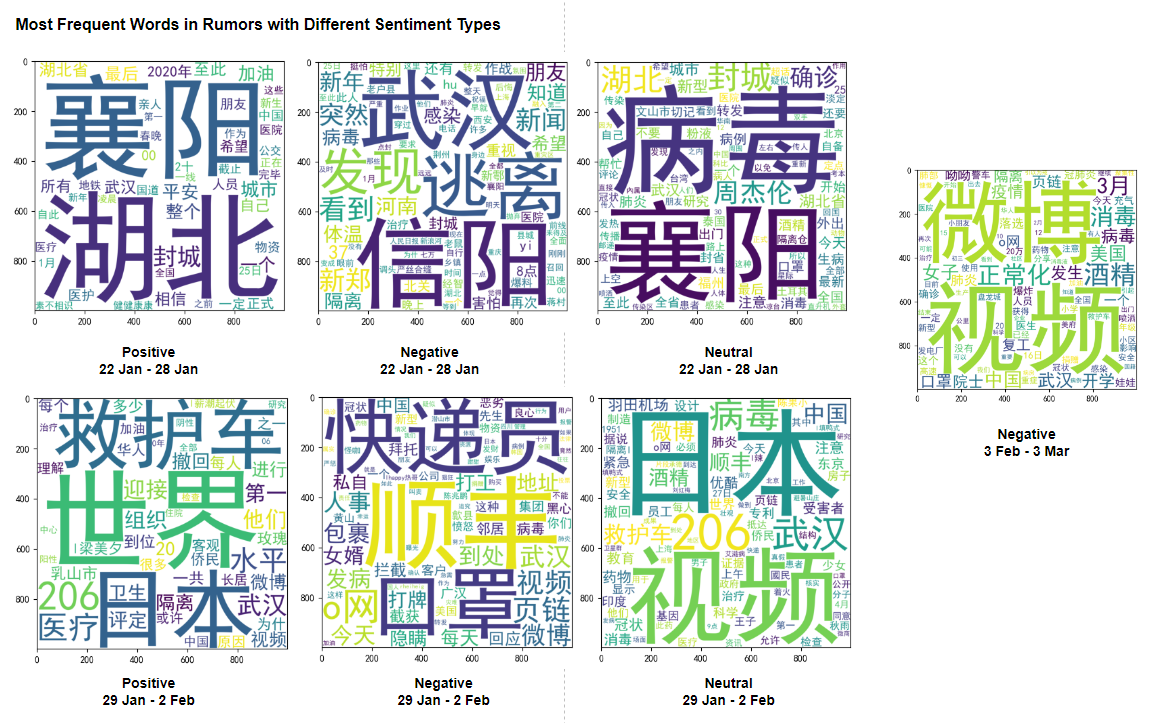

In this section, we try to quantitatively analyze the spread of epidemic rumors through the number of views, retweets, and comments; however, among the total 324 pieces of data, there are more than 300 with unknown retweet counts, so we only focus on the average number of views on different sentiment types.

In addition, we extracted and visualized the most frenquent subwords based on the sentiment type and the stage of time, which helped us to better understand the public's focus.

It can be seen from the fan chart that in the first week of Wuhan's lockdown, rumors with positive and negative emotions had similar views; neutral rumors, that is, pseudoscience-based rumors, had the most views. Since Wuhan just started to lock down the city (in the early stages of the epidemic), the public did not know much about the actual situation of the epidemic. This unknown about the symptoms also led to people’s desire to understand the full picture of the epidemic, prevention and treatment measures, which contributed to the spread of pseudoscience with broad audiences.  

From January 29 to February 2, although the number of rumors with positive emotions increased, the number of views of rumors with positive and neutral emotions dropped significantly. Rumors of negative emotions were widely viewed, and as time went on and the epidemic was still not under control, the public felt more panic. At the same time, as the demand for anti-epidemic supplies and other guarantees increased, more anxiety, even anger has also arisen.  

From February 3 to March 3, all rumors appearing in the dataset are negative rumors. This is obviously counterintuitive, mainly because we have so little data available. However, we can still speculate on the distribution trend of pageviews based on the above two sections. That is, people want to have their negative feelings been heard more, and the public are also more attentive to how others feel during difficult times (empathy).  

More accurate emotional changes in rumors require the support of more data, and the differences in people's attention to information containing different emotions also require a deeper sociological or psychological background.

### 4.4 Emotional Analysis Based on Emotional Lexicon  

We used an emotional lexicon to get more detailed sentiment classification based on seven emotion types: happiness, fear, surprise, sadness, evil, anger and unknown. The lexicon is from: https://ir.dlut.edu.cn/info/1013/1142.htm.  

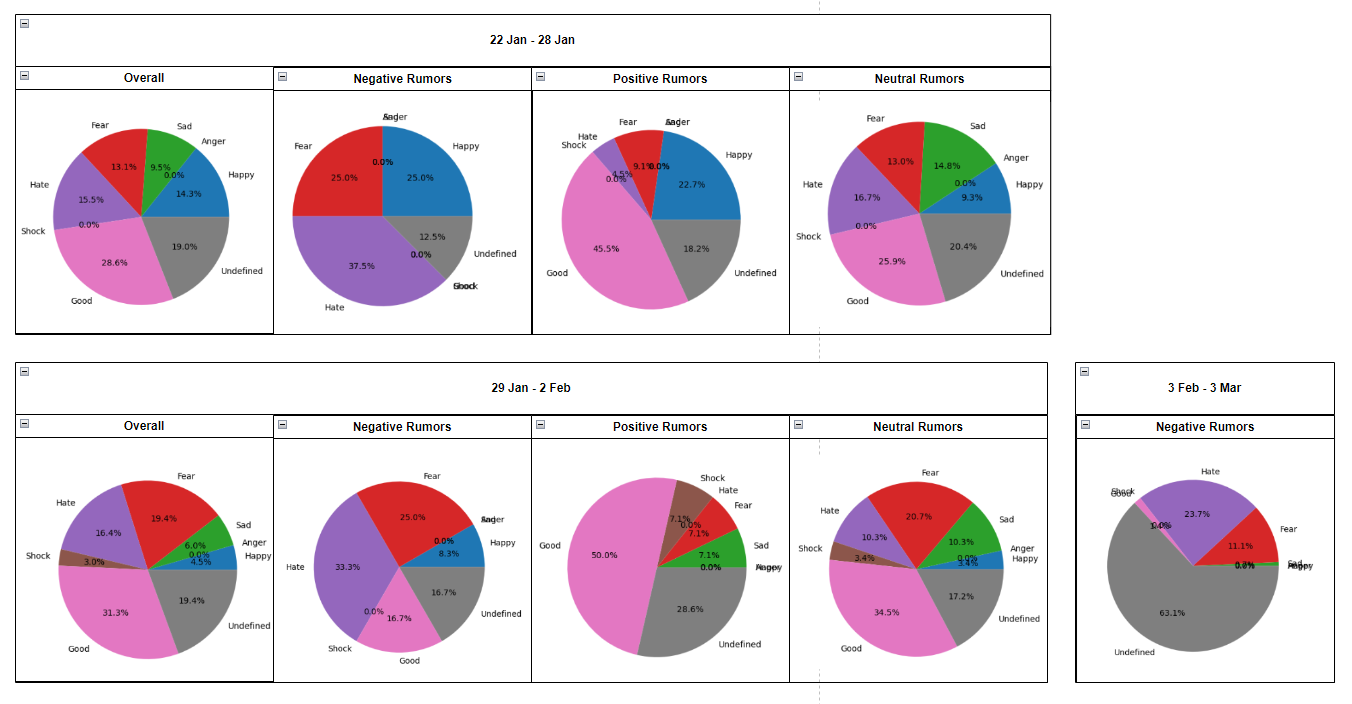    

The diagram shows a fine-grained division of rumors of different polarities for different time periods. The content of many negative-polarity rumors is unknown, and only the rumors that can be obtained are observed here, so the proportion of fine-grained emotion divisions in the chart may not be accurate. It should be noted that "good" in emotion classification is more inclined to emotions such as wishes and belief, and does not appear entirely based on information polarity.  

In the initial stages of the epidemic (within the first week of Wuhan’s lockdown), negative rumors were dominated by disgust and fear. A quarter of them are emotions of joy. By looking up corresponding examples, we can find that this emotion mainly comes from: 1. The lockdown coincides with the Chinese Spring Festival; 2. People are cheering for the control of the epidemic. Most of the disgust and fear come from annoyance about not closing the city earlier, and panic about the lockdown and the disease. The positive emotion rumors at this stage are mainly blessings and prayers, while the fine-grained emotions in neutral rumors are relatively evenly distributed, because most of the neutral rumors at this stage are pseudoscientific remarks related to the epidemic and epidemic prevention.  

From January 29 to February 2, the main Weibo rumors were: 1. Japan evacuated overseas Japanese from Wuhan; 2. SF Express misappropriated epidemic prevention supplies; 3. The United States developed a specific drug to suppress the coronavirus. Rumors about Japan's evacuation (positive polarity) demonstrate the power of the country, which inspires a large scope of discussion. This is also the reason why the proportion of good emotions in positive and neutral rumors increases. Rumors that SF Express had misappropriated anti-epidemic supplies also caused people’s shock and disgust to soar. As the epidemic worsens and rumors about related research emerge, people are becoming more panicked.  

From February 3 to March 3, since our data set only has rumors of negative polarity, we will only conduct analysis based on existing data. It can be seen that sad emotions began to appear, people were more affected by the tragedy caused by the epidemic, and the emotions related to prayer began to decrease greatly. At the same time, rumors spread wildly during this period, such as "A Chinese woman received a green card from the United States, generously donated 200,000 masks to the United States, and said, "I am not Chinese." This unpatriotic behavior also filled the public with derogatory comments.

### 4.5 Emotional Analysis on Rumor Comments Based on Emotional Lexicon  

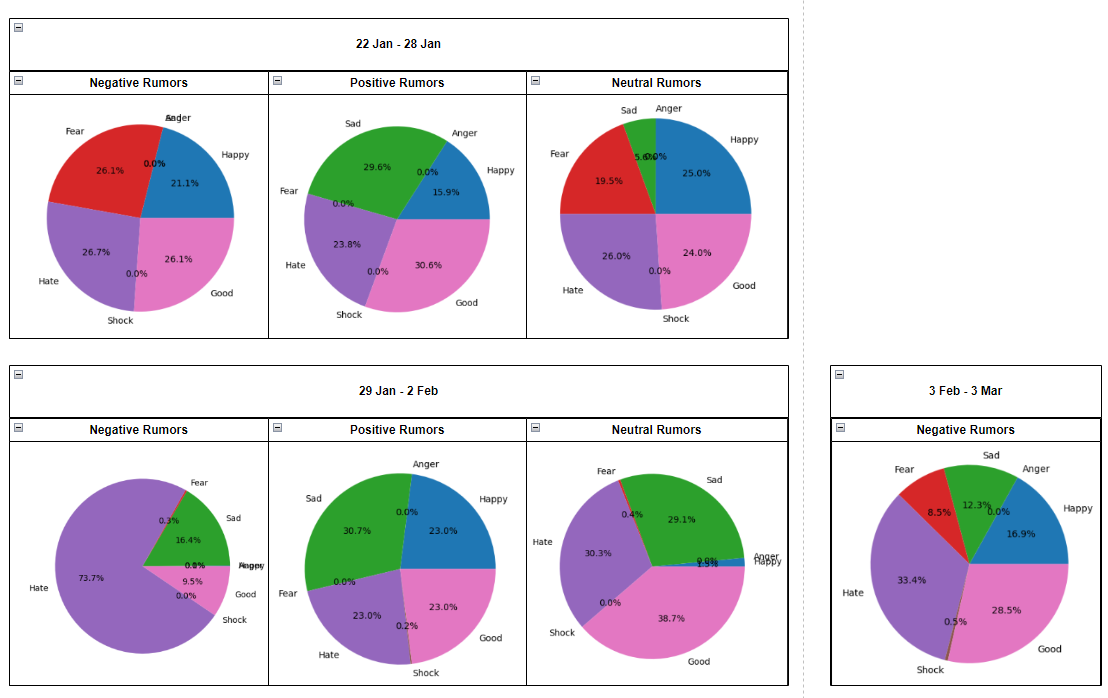  

We will conduct a fine-grained sentiment analysis on the comments of the rumors. It is worth mentioning that many comments are missing from the original data. It is speculated that it may be because the rumors are spread too widely and cause too many negative emotions, which leads to the blocking of relevant information and delete.  

In the early days of the epidemic, since the impact of the epidemic had not yet spread across the country, good and happy accounted for nearly half of the proportion of rumors. Negative rumors mainly focus on information about the lockdown and information about people escaping from the lockdown. Disgust and fear accounted for more than half of the comments, mainly "refuting rumors" and fear of closing the city; the other half were good and happy emotions to cheer up the fight against the epidemic. There are also many positive rumors that are mainly about closing the city, they are classified as positive due to expressions similar to "Sealing a province to protect a country's people". In the comments of such rumors, blessings dominate the comments. There are still a lot of sad or hate comments, mainly condemning the untimely closure of the city and worrying about the people affected by the epidemic. There are also schadenfreude comments that are similar to "hahahaha". However, the model we built did not do a good job of integrating this, such emotions are distinguished directly under the happy category.  

The analysis from January 29 to February 2 requires reference to the fine-grained sentiment analysis of the rumor itself in the previous section. During this period, negative rumors were mainly about SF Express secretly intercepting materials to fight against the epidemic. From the comments, we can feel that people have strong disgust and pessimism about this bad incident that affects personal safety. A small part of the positive segmentation  comes from "Good morning" and other comments unrelated to the incident. The positive rumors are about "Japan evacuating overseas Japanese from China", in which the four emotions of sadness, happiness, good, and disgust are relatively evenly distributed. The comments are mainly: 1. Envy of Japan's display of national power ( good); 2. Complain about China's policies (sad, hate); 3. Dislike (disgust) about spreading rumors that harm national unity. Neutral rumors are mainly social news and some popular science. Comparing charts and raw data, we can see that people have a strong ability to identify rumors, and they also have strong aversion to the spread of false news (shock, sad) . As for the news that the United States has found a way to suppress the coronavirus, the sentiments in the comments are mostly based on prayers, conspiracy theories, and anti-conspiracy theories. This is also the reason for the high proportion of good, sad, and hate.  

After February 3, many rumors were related to the news that the United States had found ways to suppress the coronavirus. This news gave many people hope that the epidemic could be quickly controlled, and the sentiment breakdown of the comments also showed this. Similar to this situation, there are rumors about the unblocking and elimination of the epidemic. The main aversion still comes from people's disgust with the spread of false news. The proportion of fear has also begun to increase, mainly due to the increasingly serious situation of the epidemic and the panic caused by many "suspected science popularization" rumors.

## Some Pseudo Code Used for Fine-grained Sentiment Classification

In [8]:
lexicon_file_path = "./data/sentiment_lexicon.xlsx"

lexicon_raw = pd.read_excel(lexicon_file_path)
lexicon_raw = lexicon_raw.iloc[:, :7]
lexicon_raw.dropna(inplace=True)

In [9]:
# inspired by: https://blog.csdn.net/qq_36489878/article/details/103826724

type_dict = {
    "happy": ["PA", "PE"],
    "anger": ["NA"],
    "sad": ["NB", "NJ", "NH", "PF"],
    "fear": ["NI", "NC", "NG"],
    "hate": ["NE", "ND", "NN", "NK", "NL"],
    "shock": ["PC"],
    "good": ["PD", "PH", "PG", "PB", "PK"]
}

# reverse dict
sent_dict = {}
for key, value in type_dict.items():
    for item in value:
        sent_dict[item] = key

# the sentiment tensity is ranked to 1, 3, 5, 7, 9, we will cast it to [0, 1] range
# the rumor dataset sentiment type is labelled as [0(neg), 1(neutral), 2(pos)], we will match the lexicon dict to same index
# lexicon also have a sentiment that indicates either praise and critism, we will remove this type for simplification 
lexicon = pd.DataFrame(columns=["word", "polarity", "sentiment", "tensity"])

for i in range(len(lexicon_raw)):
    word_info = [lexicon_raw.iloc[i,0]]

    # polarity
    orig_polarity = lexicon_raw.iloc[i,6]
    if orig_polarity == 0:
        word_info.append(1)
    elif orig_polarity == 1:
        word_info.append(2)
    elif orig_polarity == 2:
        word_info.append(0)
    else: 
        word_info.append(3)

    # sentiment
    orig_type = lexicon_raw.iloc[i,4].replace(" ", "")  # some date is not clean
    word_info.append(sent_dict[orig_type])

    # tensity
    emotion_weight = 0
    orig_tensity = lexicon_raw.iloc[i,5]
    word_info.append(orig_tensity/25)  # normailze by sum of [1,3,5,7,9]
    
    lexicon.loc[len(lexicon.index)] = word_info

In [ ]:
lexicon = lexicon.drop_duplicates(subset='word', keep="last")
lexicon = lexicon.reset_index(drop=True)
lexicon

#### 4.4.2 Calculate Sentiment

In [11]:
import jieba

from ast import literal_eval

In [ ]:
# we only extract the rumor data with contents, there can be many samples as Nan, we will ignore them
rumor_data = rumor_data[~rumor_data["action_texts"].isna()].reset_index(drop=True)
rumor_data

In [13]:
def get_topk_sentiment(scores, k=3):
    topk_sent = []
    temp = sorted(scores, reverse=True)
    for i in range(k):
        topk_sent.append(scores.index(temp[i]))
    return topk_sent

In [ ]:
rumor_sentiments = []

for i in range(len(rumor_data)):
    comments = literal_eval(rumor_data.at[i, "action_texts"])
    happy_score, anger_score, sad_score, fear_score, hate_score, suprise_score, good_score = 0, 0, 0, 0, 0, 0, 0
    for comment in comments:
        cut = jieba.cut(comment, cut_all=True)
        segments = list(cut)
    
        for segment in segments:
            lexicon_index = lexicon.index[lexicon['word'] == segment].tolist()
            if not lexicon_index:
                continue
            word_indict_index = lexicon_index[0]
            word_sentiment = lexicon.iloc[word_indict_index, 2]
            
            word_tensity = lexicon.iloc[word_indict_index, 3]
    
            """if word_polarity in [0, 1, 2]:
                score = word_tensity * segment_polarity_logits[word_polarity]
            else:
                score = (
                    (word_tensity * segment_polarity_logits[0] + word_tensity * segment_polarity_logits[2])
                    /(segment_polarity_logits[0] + segment_polarity_logits[2]))"""
            score = word_tensity

            if word_sentiment == "happy":
                happy_score += score
            elif word_sentiment == "anger":
                anger_score += score
            elif word_sentiment == "sad":
                sad_score += score
            elif word_sentiment == "fear":
                fear_score += score
            elif word_sentiment == "hate":
                hate_score += score
            elif word_sentiment == "shock":
                suprise_score += score
            elif word_sentiment == "good":
                good_score += score
    score_list = [happy_score, anger_score, sad_score, fear_score, hate_score, suprise_score, good_score]
    top_sentiment = get_topk_sentiment(score_list, 4)
    sentiment = []
    for i, sent in enumerate(top_sentiment):
        if score_list[sent] <= 0.0:
            if not sentiment:
                sentiment.append(-1)
            break
        sentiment.append(sent)
    print(sentiment)
    rumor_sentiments.append(sentiment)

rumor_data["comment_sentiment"] = rumor_sentiments

    

In [ ]:
rumor_dates = list(rumor_data["date"].values)

dates = set(rumor_dates)
dates = list(dates)

def sortDates(datesList):
   # splitting the list of elements based on the '-' separator
   split_up = datesList.split('-')

   # returning the year, the month of input list elements
   # Here split_up[1] gives the year and split_up[0] gives month
   return split_up[1], split_up[2]

sorted_dates = sorted(dates, key=sortDates)

sorted_dates.index('2020-01-28')

stage1_dates = sorted_dates[:7]
stage2_dates = sorted_dates[7:12]
stage3_dates = sorted_dates[12:]

stage1_dates, stage2_dates, stage3_dates

In [138]:
stage1_rumor = rumor_data[rumor_data["date"].isin(stage3_dates)].reset_index(drop=True)

stage1_neg = stage1_rumor[stage1_rumor["情感倾向"]==0].reset_index(drop=True)
stage1_neutral = stage1_rumor[stage1_rumor["情感倾向"]==1].reset_index(drop=True)
stage1_pos = stage1_rumor[stage1_rumor["情感倾向"]==2].reset_index(drop=True)

emotion_count = [0]*(7+1)  # the last one is unknown
for i in range(len(stage1_neg)):
    sentiments = stage1_neg.at[i, "comment_sentiment"]
    for sentiment in sentiments:
        emotion_count[sentiment] += 1/len(stage1_rumor.at[i, "action_texts"])
print(emotion_count)
    

[0.3381181289546077, 0, 0.24505712493921017, 0.16936686530696388, 0.6668099276162118, 0.009626721922497038, 0.5700075313751836, 16.913793900778128]


([<matplotlib.patches.Wedge at 0x28bbadadc60>,
 [Text(0.9483171946524711, 0.5573997652730645, 'Happy'),
  Text(0.5351009121336958, 0.9610759667339971, 'Anger'),
  Text(0.13484786539294152, 1.0917032807493834, 'Sad'),
  Text(-0.5545747342768261, 0.9499720333261332, 'Fear'),
  Text(-1.059635606915469, -0.2952496918827952, 'Hate'),
  Text(-0.2571674865442598, -1.0695161914924467, 'Shock'),
  Text(0.6873669457966061, -0.8587937364852202, 'Good')],
 [Text(0.5172639243558933, 0.30403623560348964, '16.9%'),
  Text(0.2918732248001977, 0.5242232545821801, '0.0%'),
  Text(0.07355338112342265, 0.5954745167723909, '12.3%'),
  Text(-0.3024953096055415, 0.5181665636324362, '8.5%'),
  Text(-0.5779830583175286, -0.16104528648152464, '33.4%'),
  Text(-0.14027317447868715, -0.5833724680867891, '0.5%'),
  Text(0.37492742497996695, -0.4684329471737564, '28.5%')])

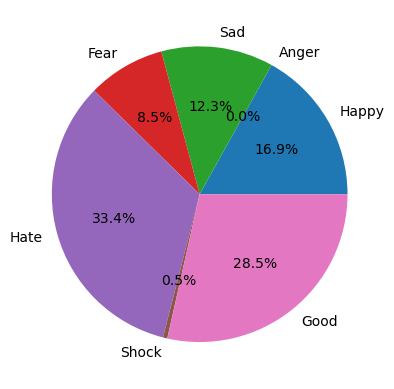

In [77]:

labels = 'Happy', 'Anger', 'Sad', 'Fear', "Hate", "Shock", "Good"
fig, ax = plt.subplots()
ax.pie(emotion_count[:-1], labels=labels, autopct='%1.1f%%')

In [61]:
rumor_neg_count, rumor_pos_count, rumor_neutral_count = [], [], []
weibo_neg_count, weibo_pos_count, weibo_neutral_count = [], [], []


for date in sorted_dates:
    day_rumor_amount = len(rumor_data[rumor_data["date"]==date])
    #print(day_rumor_amount)
    if day_rumor_amount == 0:
        rumor_neg_count.append(0)
        rumor_pos_count.append(0)
        rumor_neutral_count.append(0)
    else:
        rumor_neg_count.append(len(rumor_data[(rumor_data["date"]==date) & (rumor_data["情感倾向"]==0)])/day_rumor_amount)
        rumor_pos_count.append(len(rumor_data[(rumor_data["date"]==date) & (rumor_data["情感倾向"]==2)])/day_rumor_amount)
        rumor_neutral_count.append(len(rumor_data[(rumor_data["date"]==date) & (rumor_data["情感倾向"]==1)])/day_rumor_amount)

    day_weibo_amount = len(full_data[full_data["time"]==date])
    if day_weibo_amount == 0:
        weibo_neg_count.append(0)
        weibo_pos_count.append(0)
        weibo_neutral_count.append(0)
    else:
        weibo_neg_count.append(len(full_data[(full_data["time"]==date) & (full_data["情感倾向"]==-1)])/day_weibo_amount)
        weibo_pos_count.append(len(full_data[(full_data["time"]==date) & (full_data["情感倾向"]==1)])/day_weibo_amount)
        weibo_neutral_count.append(len(full_data[(full_data["time"]==date) & (full_data["情感倾向"]==0)])/day_weibo_amount)

time_log['rumor_neg_count'] = rumor_neg_count
time_log['rumor_pos_count'] = rumor_pos_count
time_log['rumor_neutral_count'] = rumor_neutral_count
time_log['weibo_neg_count'] = weibo_neg_count
time_log['weibo_pos_count'] = weibo_pos_count
time_log['weibo_neutral_count'] = weibo_neutral_count


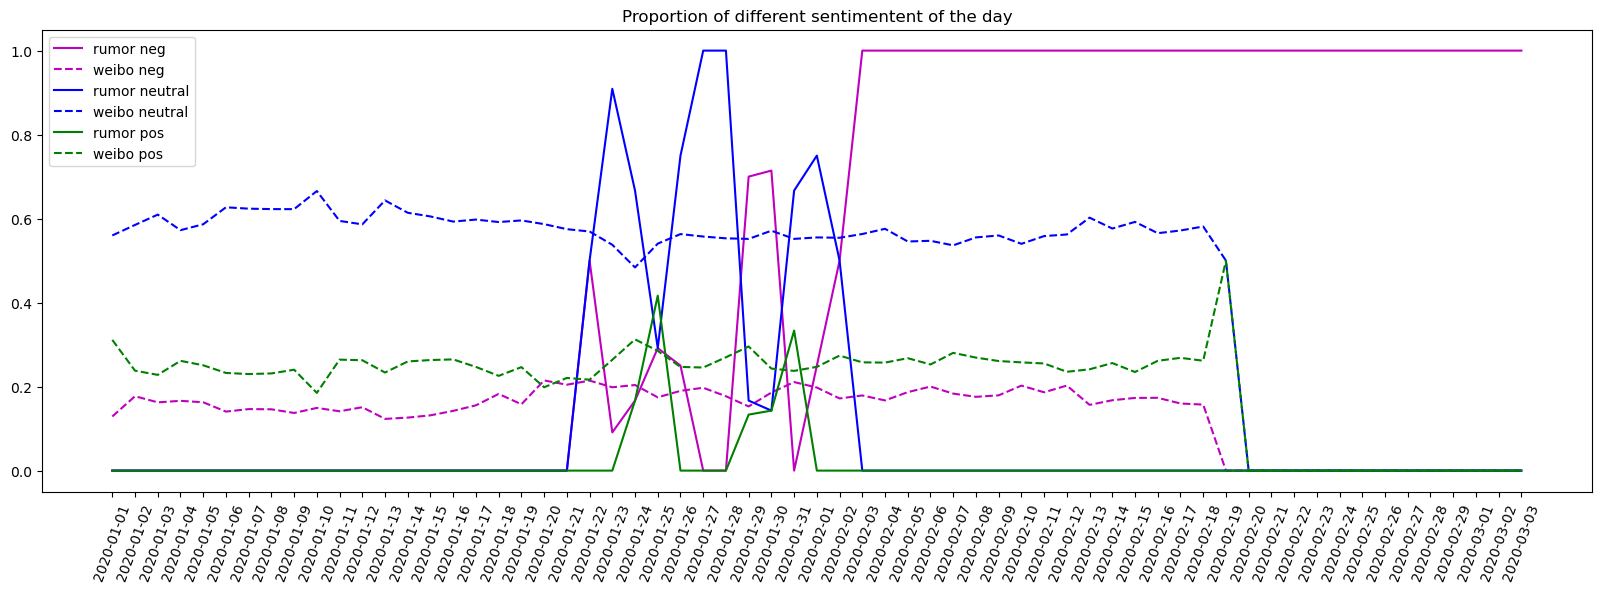

In [67]:
x = sorted_dates

plt.figure(figsize=(20,6))

plt.plot(x, rumor_neg_count, 'r', linestyle='-', label='rumor neg')
plt.plot(x, weibo_neg_count, 'r', linestyle='--', label='weibo neg')
plt.plot(x, rumor_neutral_count, 'b', linestyle='-', label='rumor neutral')
plt.plot(x, weibo_neutral_count, 'b', linestyle='--', label='weibo neutral')
plt.plot(x, rumor_pos_count, 'g', linestyle='-', label='rumor pos')
plt.plot(x, weibo_pos_count, 'g', linestyle='--', label='weibo pos')


plt.xticks(rotation=70)
plt.legend()
plt.title("Proportion of different sentimentent of the day")

plt.show()

In [170]:
def extract_TfidfVectorizer(data_train, data_test=None, max_features: int = 100, min_df: float = 0.01):
    vectorizer = TfidfVectorizer(min_df=0.01, max_features = max_features, ngram_range=(1,1))
    # fit into training data
    model = vectorizer.fit(data_train)
    feature_name = model.get_feature_names_out()
    features_train = model.transform(data_train).toarray()
    features_test = None
    if data_test:
        features_test = model.transform(data_test).toarray()
    return feature_name, features_train, features_test, model

def draw_word_cloud(label, feature_train, max_words=200):
    plt.rcParams['font.sans-serif']='SimHei'
    freq_data_frame = pd.DataFrame(feature_train, columns=label)
    feature_mean_freq_dict = dict(freq_data_frame.mean())
    word_cloud = WordCloud(background_color="white",width=1000,height=1000, 
                           max_words=max_words,relative_scaling=0.5,normalize_plurals=False,
                          font_path='simhei.ttf', prefer_horizontal=1).generate_from_frequencies(feature_mean_freq_dict)
    plt.imshow(word_cloud)

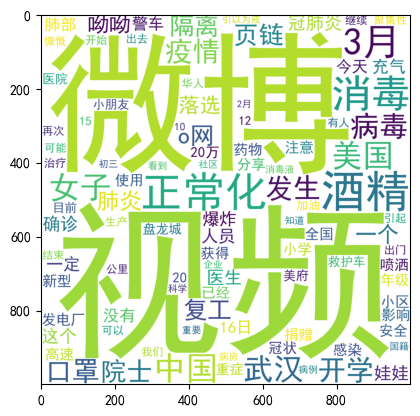

In [176]:
feature_name, features_value, features_test, model = extract_TfidfVectorizer(final_neg, None, 500, 0.01)
draw_word_cloud(feature_name, features_value, 100)